In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Starting point

In [6]:
# Define file paths
DATA_DIR = Path('.\Inputs')
# Load data from CSV files
windgen  = pd.read_csv(DATA_DIR / 'Capacity of wind farms.csv', sep=';')
wind_cf = pd.read_excel(DATA_DIR / 'windpower.xlsx')
demand  = pd.read_csv(DATA_DIR / 'Loads.csv', sep=';')
load_dist = pd.read_csv(DATA_DIR / 'ProductionConsumptionSettlement.csv', sep=';')
weather = pd.read_csv(DATA_DIR / 'Additional' / 'hourly_data.csv', sep=',')

windgen = windgen.values.T
demand = demand.values.T

# Wind generation capacity in MW
wind_cf['time'] = pd.to_datetime(wind_cf['time'], format='%Y-%m-%d %H:%M')
wind_cf = wind_cf[wind_cf['time'].dt.year == 2019]
# Extract data
wind_cf = wind_cf[['time', 'electricity','wind_speed']]

# Select hourly data from 2023 and DK2
load_dist = load_dist[load_dist['PriceArea'] == "DK2"]
load_dist['HourUTC'] = pd.to_datetime(load_dist['HourUTC'], format='%Y-%m-%d %H:%M')
load_dist = load_dist[load_dist['HourUTC'].dt.year == 2019]

# Extract load data
load_consumption = load_dist[['HourUTC', 'GrossConsumptionMWh']]
load_consumption['GrossConsumptionMWh'] = load_consumption['GrossConsumptionMWh'].str.replace(',', '.').astype(float)

# Normalize data
mean_load = load_consumption['GrossConsumptionMWh'].mean()
load_consumption['GrossConsumptionMWh'] = load_consumption['GrossConsumptionMWh'] / mean_load
mean_wcf = wind_cf['electricity'].mean()
wind_cf['electricity'] = (wind_cf['electricity']) / mean_wcf

C:\Users\ismur\AppData\Local\Temp\ipykernel_20404\3276330618.py:7: DtypeWarning: Columns (5,16,21,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  load_dist = pd.read_csv(DATA_DIR / 'ProductionConsumptionSettlement.csv', sep=';')
C:\Users\ismur\AppData\Local\Temp\ipykernel_20404\3276330618.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load_consumption['GrossConsumptionMWh'] = load_consumption['GrossConsumptionMWh'].str.replace(',', '.').astype(float)
C:\Users\ismur\AppData\Local\Temp\ipykernel_20404\3276330618.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

# Daily totals rescaling

In [7]:
# Initialize datafeatures with load_consumption
datafeatures = load_consumption.copy()

# Merge the combined samples with wind_cf on the 'HourUTC' and 'time' columns
datafeatures = datafeatures.merge(wind_cf[['time', 'electricity', 'wind_speed']], left_on='HourUTC', right_on='time', how='left')

# Drop the redundant 'time' column
datafeatures.drop(columns=['time'], inplace=True) 

datafeatures['ts'] = pd.to_datetime(datafeatures['HourUTC'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
datafeatures = datafeatures.sort_values(by='ts')

# Loads and wind farm profiles

In [8]:
# Total demand and wind capacity
windcapacity = windgen.sum()
totaldemand = demand.sum()

# Rescale of total demand and wind production from real data
datafeatures['TotalDemand'] = datafeatures['GrossConsumptionMWh']*totaldemand
datafeatures['TotalWind'] = datafeatures['electricity']*windcapacity

# Random allocation along the different wind farms
for i in range(windgen.shape[1]):
    mean_wind = windgen[0, i]
    random_values = np.random.uniform(low=0.1 * mean_wind, high=1.9 * mean_wind, size=len(datafeatures))
    scaled_values = random_values * (mean_wind / np.mean(random_values))
    datafeatures[f'W{i+1}'] = datafeatures['electricity'] * scaled_values

# Distribute the remaining wind power to the last wind farm (W2)
datafeatures['W1'] = np.where(datafeatures['W1'] > datafeatures['TotalWind'], datafeatures['TotalWind'], datafeatures['W1'])
datafeatures['W2'] = datafeatures['TotalWind'] - datafeatures['W1']

# Random allocation along the different demand points
for i in range(demand.shape[1]):
    mean_load = demand[0, i]
    random_values = np.random.uniform(low=0.3 * mean_load, high=1.7 * mean_load, size=len(datafeatures))
    scaled_values = random_values * (mean_load / np.mean(random_values))
    datafeatures[f'L{i+1}'] = datafeatures['GrossConsumptionMWh'] * scaled_values

# Distribute the remaining wind power to the last wind farm (L3)
excess_demand = datafeatures['L1'] + datafeatures['L2'] - datafeatures['TotalDemand']
datafeatures['L2'] = np.where(excess_demand > 0, datafeatures['L2'] - excess_demand, datafeatures['L2'])
datafeatures['L3'] = datafeatures['TotalDemand'] - datafeatures['L1'] - datafeatures['L2']

# Verify that the total demand and wind production are preserved
assert np.allclose(datafeatures['L1'] + datafeatures['L2'] + datafeatures['L3'], datafeatures['TotalDemand'])
assert np.allclose(datafeatures['W1'] + datafeatures['W2'], datafeatures['TotalWind'])

In [9]:
mean_Demand = datafeatures['TotalDemand'].mean()
mean_TotalWind = datafeatures['TotalWind'].mean()

mean_L1 = datafeatures['L1'].mean()
mean_L2 = datafeatures['L2'].mean()
mean_L3 = datafeatures['L3'].mean()
mean_W1 = datafeatures['W1'].mean()
mean_W2 = datafeatures['W2'].mean()

print(f"Mean L1: {mean_L1}")
print(f"Mean L2: {mean_L2}")
print(f"Mean L3: {mean_L3}")
print(f"Mean W1: {mean_W1}")
print(f"Mean W2: {mean_W2}")
print(f"TotalDemand: {mean_Demand}")
print(f"TotalWind: {mean_TotalWind}")

Mean L1: 55.99581819872599
Mean L2: 111.88568931261234
Mean L3: 112.11849248866167
Mean W1: 27.293775315847757
Mean W2: 12.706224684152238
TotalDemand: 280.0
TotalWind: 39.99999999999999


In [10]:
datafeatures = datafeatures.drop(columns=['GrossConsumptionMWh', 'electricity'])
datafeatures = datafeatures.drop(columns=['HourUTC'])
cols = ['ts'] + [col for col in datafeatures if col != 'ts']
datafeatures = datafeatures[cols]

# Seasonal Features

In [11]:
# extract the hour from the timestamp and add it as a new column
datafeatures['hour'] = datafeatures['ts'].dt.hour
datafeatures['day'] = datafeatures['ts'].dt.day
datafeatures['month'] = datafeatures['ts'].dt.month
datafeatures['hour_of_year'] = range(len(datafeatures))

# stationality variables
datafeatures[f'cos_hour_day'] = np.cos(2 * np.pi * datafeatures['hour'] / 24)
datafeatures[f'sin_hour_day'] = np.sin(2 * np.pi * datafeatures['hour'] / 24)
datafeatures[f'cos_day_month'] = np.cos(2 * np.pi * datafeatures['day'] / 30.4)
datafeatures[f'sin_day_month'] = np.sin(2 * np.pi * datafeatures['day'] / 30.4)
datafeatures[f'cos_month_year'] = np.cos(2 * np.pi * datafeatures['month'] / 12)
datafeatures[f'sin_month_year'] = np.sin(2 * np.pi * datafeatures['month'] / 12)
datafeatures[f'cos_hour_year'] = np.cos(2 * np.pi * datafeatures['hour_of_year'] / 8759)
datafeatures[f'sin_hour_year'] = np.sin(2 * np.pi * datafeatures['hour_of_year'] / 8759)

In [12]:
datafeatures = datafeatures.drop(columns=['hour', 'day','month', 'hour_of_year'])

# Weather Features

In [14]:
weather = pd.read_csv(DATA_DIR / 'Additional' / 'hourly_data.csv', sep=',')

# Convert 'hour' column to datetime format
weather['hour'] = pd.to_datetime(weather['hour'], errors='coerce')
weather = weather[weather['hour'].dt.year == 2022]
weather['hour'] = weather['hour'].apply(lambda x: x.replace(year=2019) if x.year == 2022 else x)
# Fill missing values
full_time_range = pd.date_range(start='2019-01-01 00:00:00', end='2019-12-31 23:00:00', freq='H')
weather.set_index('hour', inplace=True)
weather = weather.reindex(full_time_range)
weather.fillna(method='bfill', inplace=True)
weather.fillna(method='ffill', inplace=True)
weather.reset_index(inplace=True)
weather.rename(columns={'index': 'hour'}, inplace=True)

weather = weather.rename(columns={
    'mean_observed_mean_temperature': 'temperature',
    'mean_observed_mean_humidity': 'humidity',
    'mean_observed_global_radiation': 'radiation',
    'mean_observed_precipitation': 'precipitation'
})

C:\Users\ismur\AppData\Local\Temp\ipykernel_20404\1721598244.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_range = pd.date_range(start='2019-01-01 00:00:00', end='2019-12-31 23:00:00', freq='H')
C:\Users\ismur\AppData\Local\Temp\ipykernel_20404\1721598244.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather.fillna(method='bfill', inplace=True)
C:\Users\ismur\AppData\Local\Temp\ipykernel_20404\1721598244.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather.fillna(method='ffill', inplace=True)


In [15]:
weather

,hour,wind_power,mean_weather_forecast_max_temp,mean_weather_forecast_wind_direction,mean_weather_forecast_precipitation,mean_weather_forecast_relative_humidity,mean_weather_forecast_wind_speed,mean_weather_forecast_y_wind,mean_weather_forecast_min_temp,mean_weather_forecast_x_wind,...,mean_BalancingPowerPriceDownEUR,mean_SpotPriceEUR,mean_observed_wind_speed,precipitation,mean_observed_max_temperature,mean_observed_min_temperature,temperature,humidity,mean_observed_wind_direction,radiation
0,2019-01-01 00:00:00,14.632626,279.843140,235.578570,0.000000,1.000007,5.813893,3.280224,279.843140,4.800692,...,32.999393,70.089996,5.8,0.2,7.4,7.1,7.2,100.0,231.0,7.0
1,2019-01-01 01:00:00,14.632626,279.843140,235.578570,0.000000,1.000007,5.813893,3.280224,279.843140,4.800692,...,32.999393,70.089996,5.8,0.2,7.4,7.1,7.2,100.0,231.0,7.0
2,2019-01-01 02:00:00,14.632626,279.843140,235.578570,0.000000,1.000007,5.813893,3.280224,279.843140,4.800692,...,32.999393,70.089996,5.8,0.2,7.4,7.1,7.2,100.0,231.0,7.0
3,2019-01-01 03:00:00,14.632626,279.843140,235.578570,0.000000,1.000007,5.813893,3.280224,279.843140,4.800692,...,32.999393,70.089996,5.8,0.2,7.4,7.1,7.2,100.0,231.0,7.0
4,2019-01-01 04:00:00,14.632626,279.843140,235.578570,0.000000,1.000007,5.813893,3.280224,279.843140,4.800692,...,32.999393,70.089996,5.8,0.2,7.4,7.1,7.2,100.0,231.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019-12-31 19:00:00,16.781320,282.753326,225.547058,1.795898,1.000006,6.229231,4.356991,282.559662,4.452120,...,1.340000,11.570000,9.8,0.0,10.4,9.8,10.1,93.0,221.0,0.0
8756,2019-12-31 20:00:00,16.749675,282.791931,227.211716,2.165039,1.000006,5.166614,3.504490,282.540710,3.795788,...,-7.000000,14.890000,8.5,0.0,10.6,9.9,10.2,94.0,227.0,0.0
8757,2019-12-31 21:00:00,14.390591,282.526947,233.590164,4.666992,1.000006,4.715191,2.793564,282.390625,3.797710,...,-7.000000,9.940000,8.6,0.3,10.6,9.7,10.1,96.0,223.0,0.0
8758,2019-12-31 22:00:00,13.039741,282.380707,225.264023,10.682617,1.000006,4.859219,3.415953,281.500061,3.456581,...,-6.720000,4.840000,7.9,0.5,9.9,9.6,9.8,98.0,233.0,0.0


In [16]:
has_nan = weather.isna().any().any()
print(has_nan)

False


In [17]:
datafeatures = pd.merge(datafeatures, weather[['hour', 'temperature', 'humidity', 'radiation', 'precipitation']], left_on='ts', right_on='hour', how='left')
datafeatures = datafeatures.drop(columns=['hour'])

In [18]:
has_nan = datafeatures.isna().any().any()
print(has_nan)

False


In [19]:
datafeatures

,ts,wind_speed,TotalDemand,TotalWind,W1,W2,L1,L2,L3,cos_hour_day,...,cos_day_month,sin_day_month,cos_month_year,sin_month_year,cos_hour_year,sin_hour_year,temperature,humidity,radiation,precipitation
0,2019-01-01 00:00:00,15.424,250.692998,75.926997,45.955839,29.971158,57.628046,150.619669,42.445283,1.000000,...,0.978717,0.205215,0.866025,5.000000e-01,1.000000,0.000000e+00,7.2,100.0,7.0,0.2
1,2019-01-01 01:00:00,16.318,245.601980,76.468228,76.468228,0.000000,20.061747,147.365054,78.175180,0.965926,...,0.978717,0.205215,0.866025,5.000000e-01,1.000000,7.173404e-04,7.2,100.0,7.0,0.2
2,2019-01-01 02:00:00,17.235,236.522778,76.622866,24.477113,52.145753,18.393842,35.326788,182.802149,0.866025,...,0.978717,0.205215,0.866025,5.000000e-01,0.999999,1.434680e-03,7.2,100.0,7.0,0.2
3,2019-01-01 03:00:00,18.193,234.216884,76.313591,25.559890,50.753701,26.095260,144.107322,64.014302,0.707107,...,0.978717,0.205215,0.866025,5.000000e-01,0.999998,2.152020e-03,7.2,100.0,7.0,0.2
4,2019-01-01 04:00:00,19.274,235.388544,75.153810,69.599720,5.554090,62.663121,72.823789,99.901634,0.500000,...,0.978717,0.205215,0.866025,5.000000e-01,0.999996,2.869358e-03,7.2,100.0,7.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019-12-31 19:00:00,9.304,304.115213,50.102540,18.891244,31.211296,20.451886,126.920202,156.743125,0.258819,...,0.992321,0.123693,1.000000,-2.449294e-16,0.999996,-2.869358e-03,10.1,93.0,0.0,0.0
8756,2019-12-31 20:00:00,9.082,290.246534,48.014934,23.099818,24.915116,83.887254,39.222661,167.136619,0.500000,...,0.992321,0.123693,1.000000,-2.449294e-16,0.999998,-2.152020e-03,10.2,94.0,0.0,0.0
8757,2019-12-31 21:00:00,9.179,278.227381,48.942759,11.818029,37.124730,67.272110,155.339043,55.616228,0.707107,...,0.992321,0.123693,1.000000,-2.449294e-16,0.999999,-1.434680e-03,10.1,96.0,0.0,0.3
8758,2019-12-31 22:00:00,9.732,269.393277,54.045795,25.513868,28.531928,77.211454,111.757763,80.424060,0.866025,...,0.992321,0.123693,1.000000,-2.449294e-16,1.000000,-7.173404e-04,9.8,98.0,0.0,0.5


# Marginal distribution

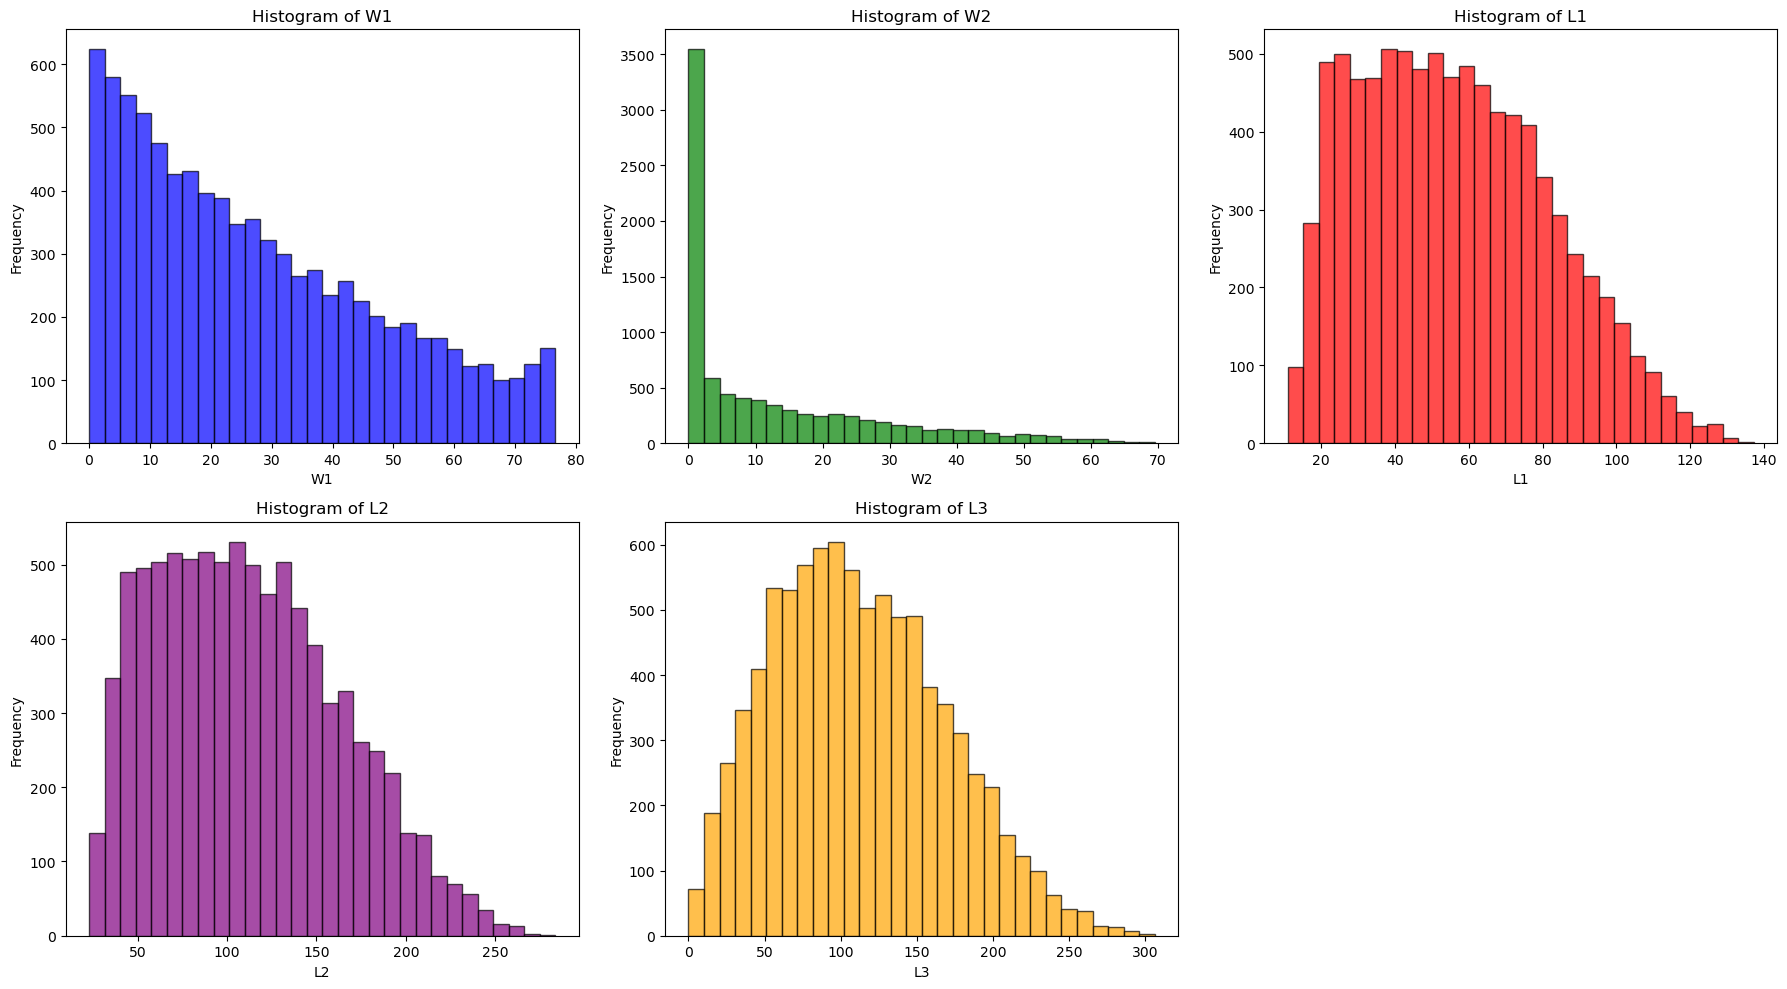

In [20]:
# Plot histograms for the wind and load samples
plt.figure(figsize=(18, 10))

# Histogram of W1
plt.subplot(2, 3, 1)
plt.hist(datafeatures['W1'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of W1')
plt.xlabel('W1')
plt.ylabel('Frequency')

# Histogram of W2
plt.subplot(2, 3, 2)
plt.hist(datafeatures['W2'], bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('Histogram of W2')
plt.xlabel('W2')
plt.ylabel('Frequency')

# Histogram of L1
plt.subplot(2, 3, 3)
plt.hist(datafeatures['L1'], bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title('Histogram of L1')
plt.xlabel('L1')
plt.ylabel('Frequency')

# Histogram of L2
plt.subplot(2, 3, 4)
plt.hist(datafeatures['L2'], bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.title('Histogram of L2')
plt.xlabel('L2')
plt.ylabel('Frequency')

# Histogram of L3
plt.subplot(2, 3, 5)
plt.hist(datafeatures['L3'], bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Histogram of L3')
plt.xlabel('L3')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

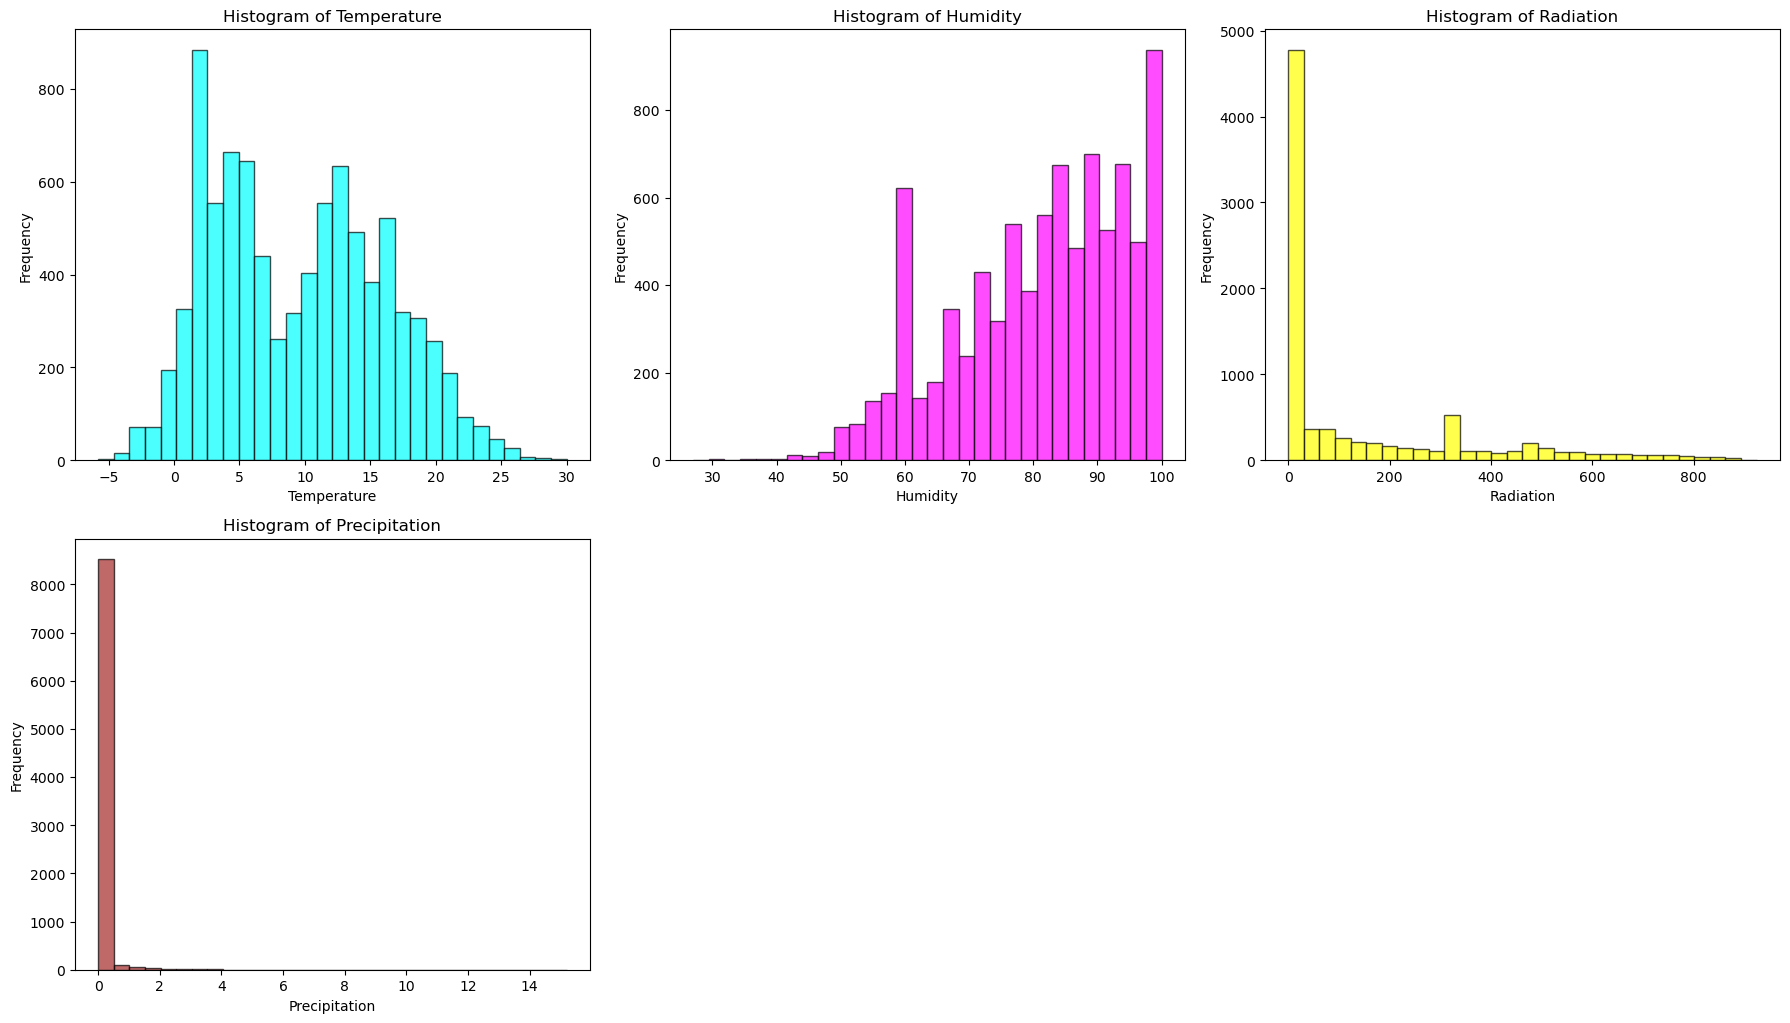

In [21]:
# Plot histograms for the wind, load samples, and weather variables
plt.figure(figsize=(18, 15))

# Histogram of Temperature
plt.subplot(3, 3, 1)
plt.hist(datafeatures['temperature'], bins=30, alpha=0.7, color='cyan', edgecolor='black')
plt.title('Histogram of Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Histogram of Humidity
plt.subplot(3, 3, 2)
plt.hist(datafeatures['humidity'], bins=30, alpha=0.7, color='magenta', edgecolor='black')
plt.title('Histogram of Humidity')
plt.xlabel('Humidity')
plt.ylabel('Frequency')

# Histogram of Radiation
plt.subplot(3, 3, 3)
plt.hist(datafeatures['radiation'], bins=30, alpha=0.7, color='yellow', edgecolor='black')
plt.title('Histogram of Radiation')
plt.xlabel('Radiation')
plt.ylabel('Frequency')

# Histogram of Precipitation
plt.subplot(3, 3, 4)
plt.hist(datafeatures['precipitation'], bins=30, alpha=0.7, color='brown', edgecolor='black')
plt.title('Histogram of Precipitation')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Time Series dynamics

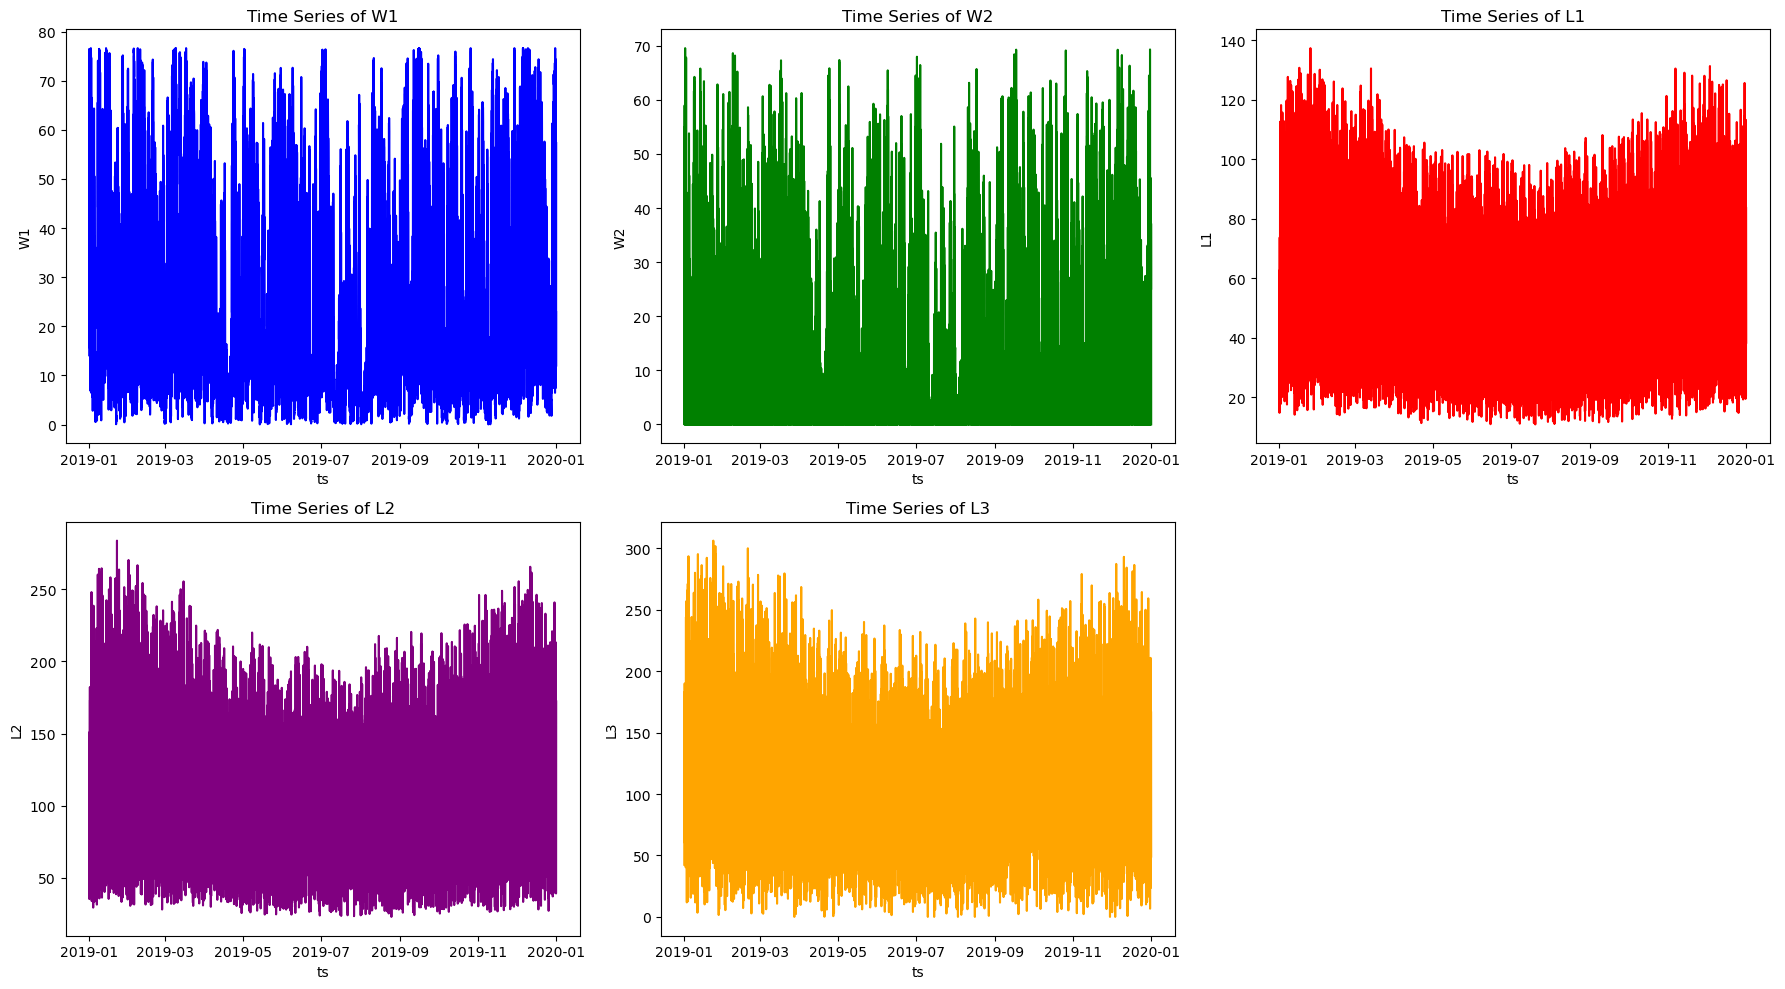

In [22]:
# Plot time series for the wind and load samples
plt.figure(figsize=(18, 10))

# Time series of W1
plt.subplot(2, 3, 1)
plt.plot(datafeatures['ts'], datafeatures['W1'], color='blue')
plt.title('Time Series of W1')
plt.xlabel('ts')
plt.ylabel('W1')

# Time series of W2
plt.subplot(2, 3, 2)
plt.plot(datafeatures['ts'], datafeatures['W2'], color='green')
plt.title('Time Series of W2')
plt.xlabel('ts')
plt.ylabel('W2')

# Time series of L1
plt.subplot(2, 3, 3)
plt.plot(datafeatures['ts'], datafeatures['L1'], color='red')
plt.title('Time Series of L1')
plt.xlabel('ts')
plt.ylabel('L1')

# Time series of L2
plt.subplot(2, 3, 4)
plt.plot(datafeatures['ts'], datafeatures['L2'], color='purple')
plt.title('Time Series of L2')
plt.xlabel('ts')
plt.ylabel('L2')

# Time series of L3
plt.subplot(2, 3, 5)
plt.plot(datafeatures['ts'], datafeatures['L3'], color='orange')
plt.title('Time Series of L3')
plt.xlabel('ts')
plt.ylabel('L3')

plt.tight_layout()
plt.show()

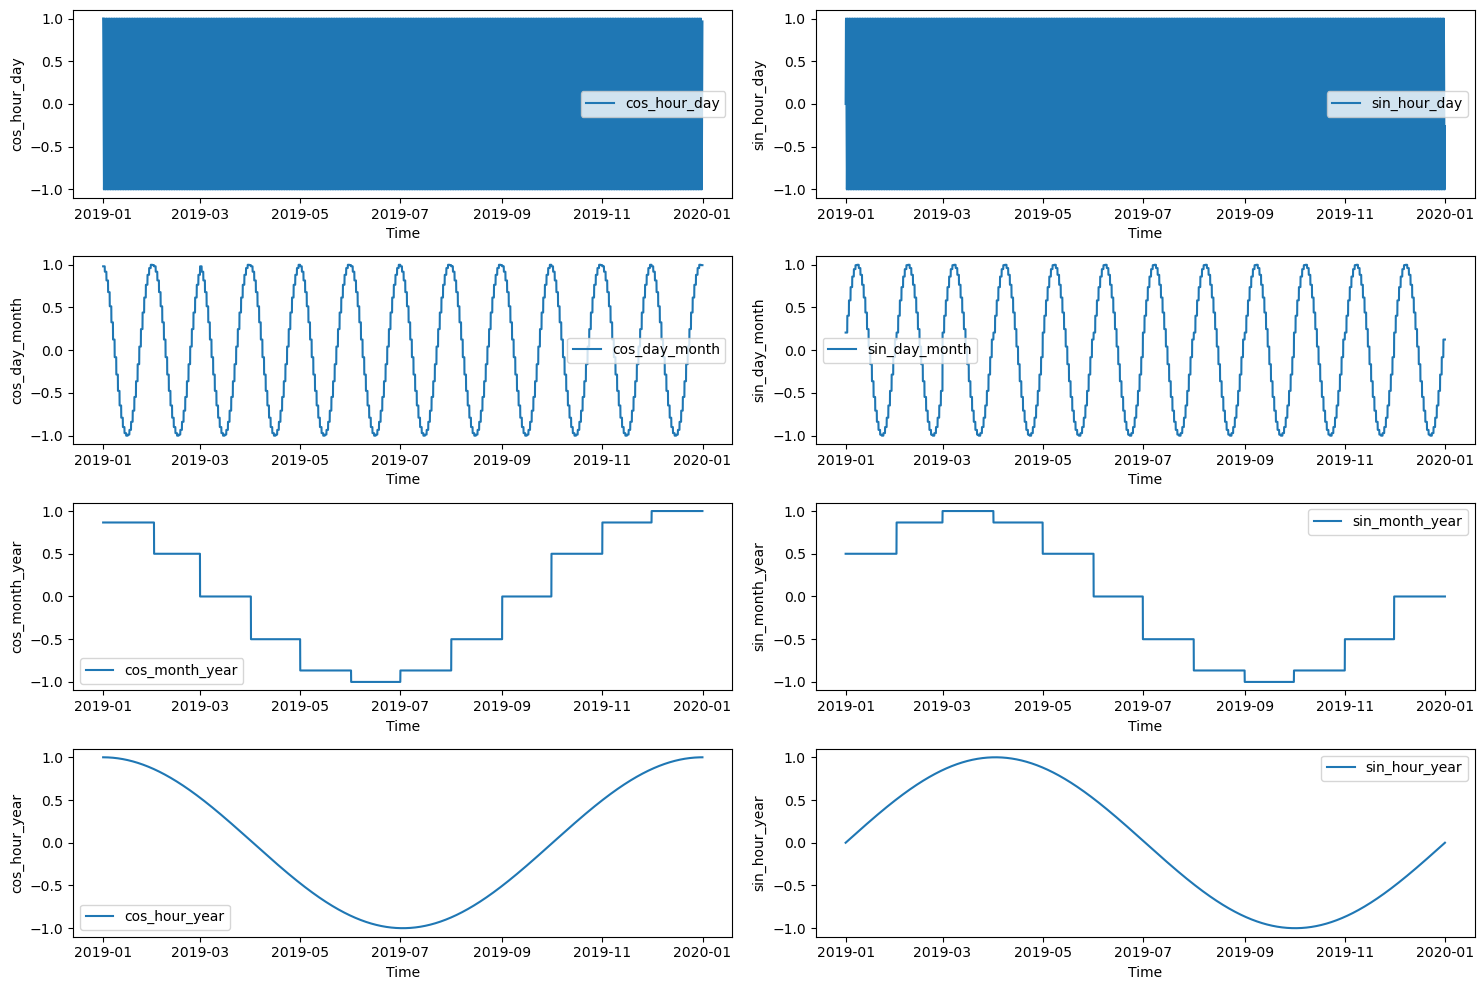

In [23]:
plt.figure(figsize=(15, 10))

plt.subplot(4, 2, 1)
plt.plot(datafeatures['ts'], datafeatures['cos_hour_day'], label='cos_hour_day')
plt.xlabel('Time')
plt.ylabel('cos_hour_day')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(datafeatures['ts'], datafeatures['sin_hour_day'], label='sin_hour_day')
plt.xlabel('Time')
plt.ylabel('sin_hour_day')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(datafeatures['ts'], datafeatures['cos_day_month'], label='cos_day_month')
plt.xlabel('Time')
plt.ylabel('cos_day_month')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(datafeatures['ts'], datafeatures['sin_day_month'], label='sin_day_month')
plt.xlabel('Time')
plt.ylabel('sin_day_month')
plt.legend()

plt.subplot(4, 2, 5)
plt.plot(datafeatures['ts'], datafeatures['cos_month_year'], label='cos_month_year')
plt.xlabel('Time')
plt.ylabel('cos_month_year')
plt.legend()

plt.subplot(4, 2, 6)
plt.plot(datafeatures['ts'], datafeatures['sin_month_year'], label='sin_month_year')
plt.xlabel('Time')
plt.ylabel('sin_month_year')
plt.legend()

plt.subplot(4, 2, 7)
plt.plot(datafeatures['ts'], datafeatures['cos_hour_year'], label='cos_hour_year')
plt.xlabel('Time')
plt.ylabel('cos_hour_year')
plt.legend()

plt.subplot(4, 2, 8)
plt.plot(datafeatures['ts'], datafeatures['sin_hour_year'], label='sin_hour_year')
plt.xlabel('Time')
plt.ylabel('sin_hour_year')
plt.legend()

plt.tight_layout()
plt.show()

# Step 2.2 Feature Selection and Data Splitting

In [ ]:
universe_data = pd.read_csv('.\Inputs\Processed\model_data_all_features IF 20241125 2110.csv', sep=',')
universe_data

,ts,wind_speed,TotalDemand,TotalWind,W1,W2,L1,L2,L3,cos_hour_day,...,e3,e4,e5,e6,d1,d2,d3,d4,d5,d6
0,1/1/2019 0:00,15.424,163.284873,39.28,29.46,9.82,32.656975,65.313949,65.313949,1.000000,...,0,0,0,0,0,0,0,0,0,0
1,1/1/2019 1:00,16.318,159.968920,39.56,29.67,9.89,31.993784,63.987568,63.987568,0.965926,...,0,0,0,0,0,0,0,0,0,0
2,1/1/2019 2:00,17.235,154.055327,39.64,29.73,9.91,30.811065,61.622131,61.622131,0.866025,...,0,0,0,0,0,0,0,0,0,0
3,1/1/2019 3:00,18.193,152.553419,39.48,29.61,9.87,30.510684,61.021368,61.021368,0.707107,...,0,0,0,0,0,0,0,0,0,0
4,1/1/2019 4:00,19.274,153.316562,38.88,29.16,9.72,30.663312,61.326625,61.326625,0.500000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,12/31/2019 19:00,9.304,198.080578,25.92,19.44,6.48,39.616116,79.232231,79.232231,0.258819,...,0,0,0,0,0,0,0,0,0,0
8756,12/31/2019 20:00,9.082,189.047436,24.84,18.63,6.21,37.809487,75.618974,75.618974,0.500000,...,0,0,0,0,0,0,0,0,0,0
8757,12/31/2019 21:00,9.179,181.218953,25.32,18.99,6.33,36.243791,72.487581,72.487581,0.707107,...,0,0,0,0,0,0,0,0,0,0
8758,12/31/2019 22:00,9.732,175.465001,27.96,20.97,6.99,35.093000,70.186000,70.186000,0.866025,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# count the number of 1s and 0s in column 'u1', 'u2', 'u3'
print('u1:', universe_data['u1'].value_counts())
print('u2:', universe_data['u2'].value_counts())
print('u3:', universe_data['u3'].value_counts())

u1: u1
1    8760
Name: count, dtype: int64
u2: u2
1    8367
0     393
Name: count, dtype: int64
u3: u3
0    8270
1     490
Name: count, dtype: int64


In [26]:
# Ensure 'ts' column is in datetime format
universe_data['ts'] = pd.to_datetime(universe_data['ts'], errors='coerce')

# create a column whether it is a weekday
universe_data['weekday'] = universe_data['ts'].dt.weekday.astype('int32')
universe_data['weekday'] = universe_data['weekday'].apply(lambda x: 1 if x < 5 else 0).astype('int32')

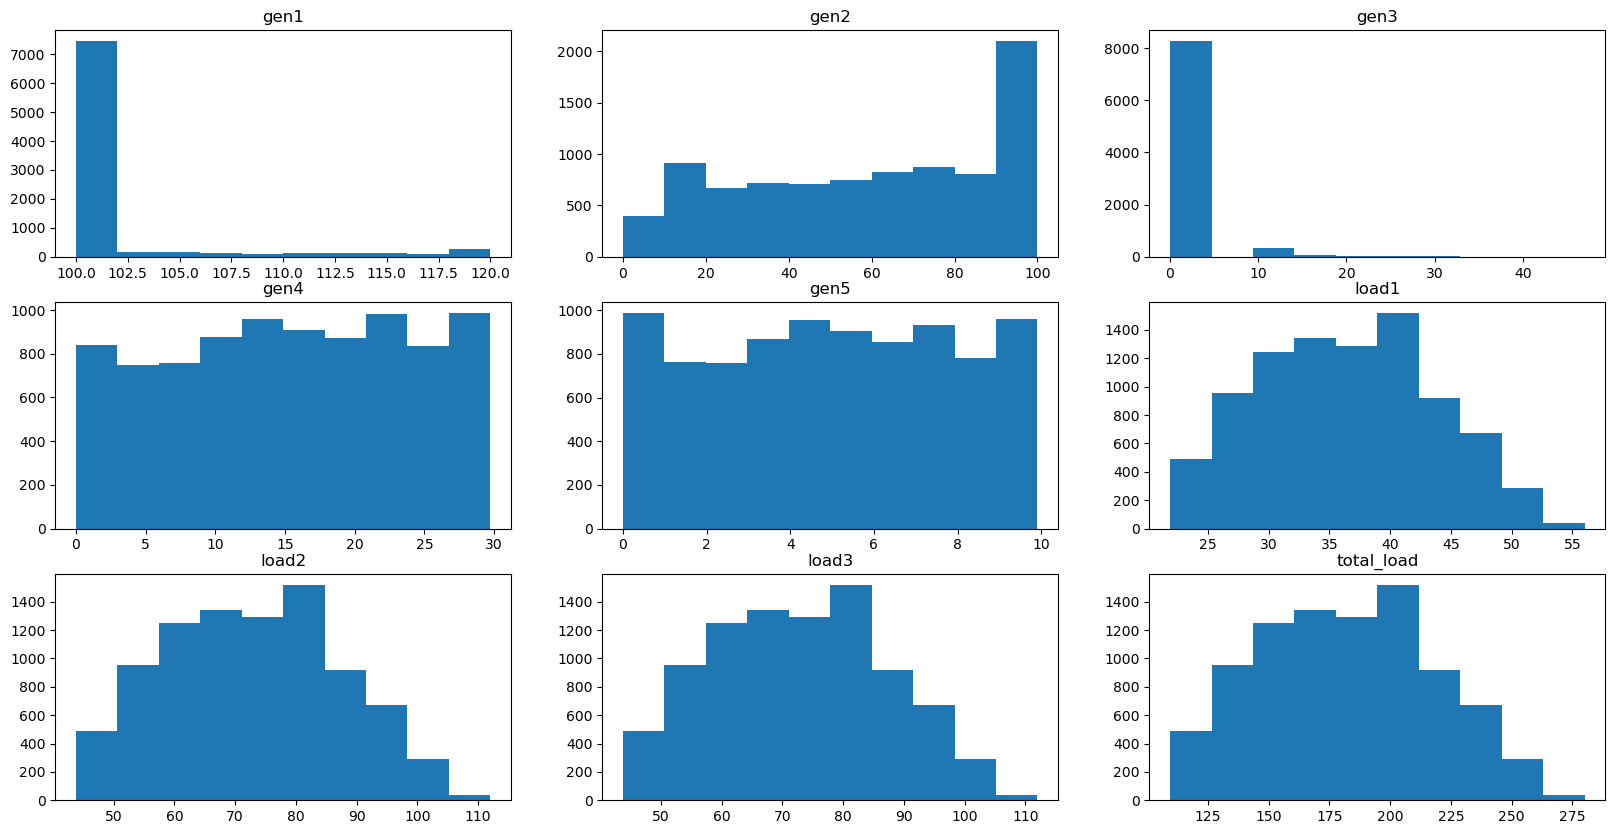

In [27]:
# create subplots filled with histograms of gen and load
fig, axs = plt.subplots(3, 3, figsize=(20,10))
axs[0, 0].hist(universe_data['gen1'])
axs[0, 0].set_title('gen1')
axs[0, 1].hist(universe_data['gen2'])
axs[0, 1].set_title('gen2')
axs[0, 2].hist(universe_data['gen3'])
axs[0, 2].set_title('gen3')
axs[1, 0].hist(universe_data['gen4'])
axs[1, 0].set_title('gen4')
axs[1, 1].hist(universe_data['gen5'])
axs[1, 1].set_title('gen5')
axs[1, 2].hist(universe_data['L1'])
axs[1, 2].set_title('load1')
axs[2, 0].hist(universe_data['L2'])
axs[2, 0].set_title('load2')
axs[2, 1].hist(universe_data['L3'])
axs[2, 1].set_title('load3')
axs[2, 2].hist(universe_data['TotalDemand'])
axs[2, 2].set_title('total_load')
plt.show()

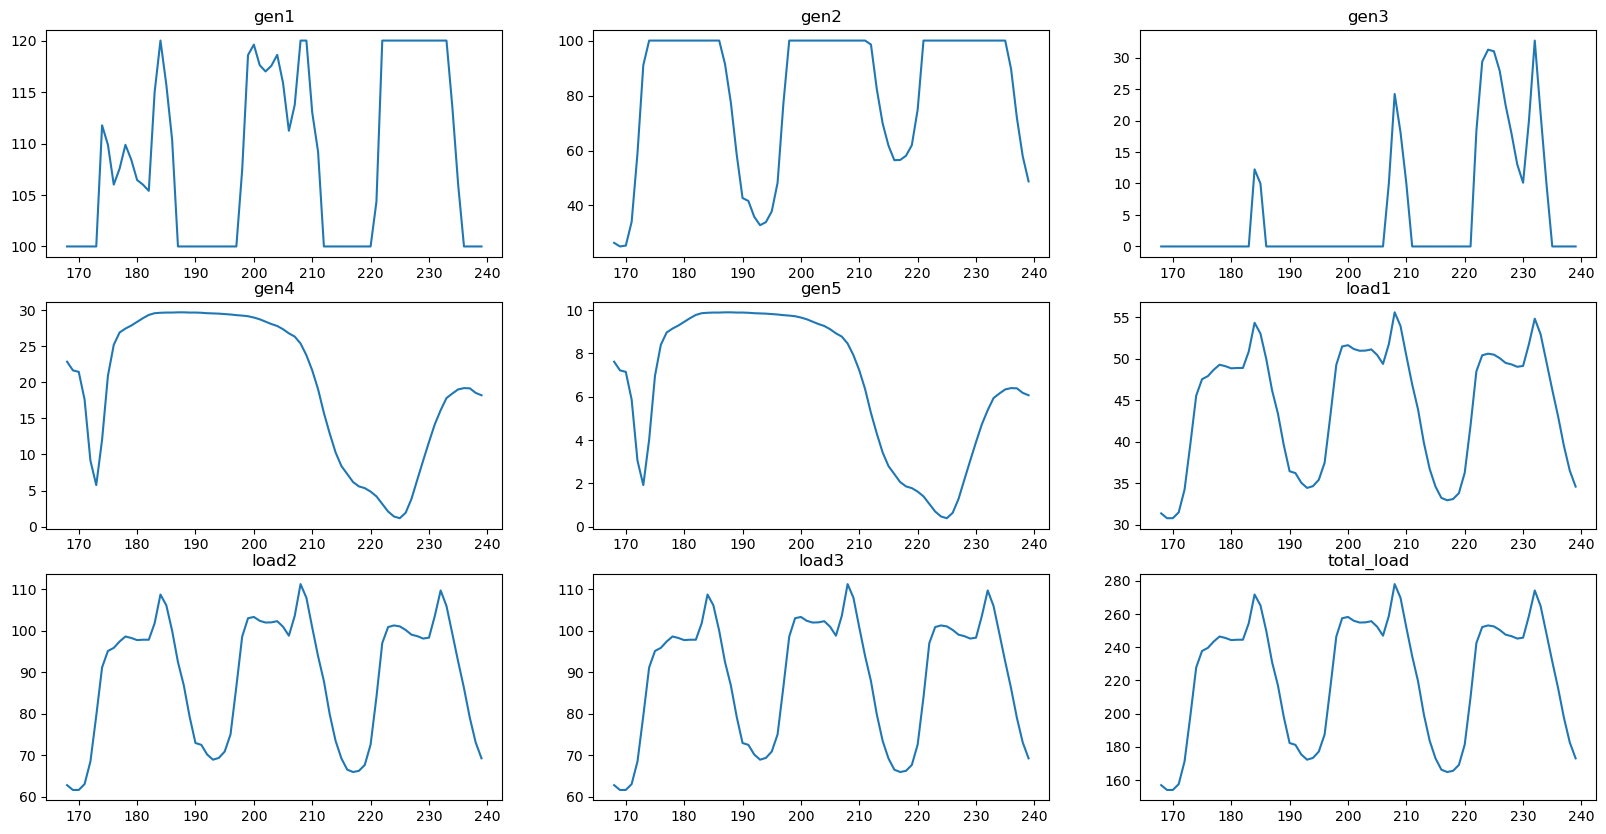

In [28]:
# create subplot to see the timeseries starting from m to n for gen and load
show_start, show_length = 7*24, 3*24
mult = 10
fig, axs = plt.subplots(3, 3, figsize=(2*mult,1*mult))
axs[0, 0].plot(universe_data['gen1'][show_start:(show_start+show_length)])
axs[0, 0].set_title('gen1')
axs[0, 1].plot(universe_data['gen2'][show_start:(show_start+show_length)])
axs[0, 1].set_title('gen2')
axs[0, 2].plot(universe_data['gen3'][show_start:(show_start+show_length)])
axs[0, 2].set_title('gen3')
axs[1, 0].plot(universe_data['gen4'][show_start:(show_start+show_length)])
axs[1, 0].set_title('gen4')
axs[1, 1].plot(universe_data['gen5'][show_start:(show_start+show_length)])
axs[1, 1].set_title('gen5')
axs[1, 2].plot(universe_data['L1'][show_start:(show_start+show_length)])
axs[1, 2].set_title('load1')
axs[2, 0].plot(universe_data['L2'][show_start:(show_start+show_length)])
axs[2, 0].set_title('load2')
axs[2, 1].plot(universe_data['L3'][show_start:(show_start+show_length)])
axs[2, 1].set_title('load3')
axs[2, 2].plot(universe_data['TotalDemand'][show_start:(show_start+show_length)])
axs[2, 2].set_title('total_load')
plt.savefig(r'./figures/timeseries.png')
plt.show()

Features:
Weather forecast to capture wind production
Weekday/weekend to capture weekly load profile
Hour to capture daily load and wind profile

In [ ]:
Feed_Data = universe_data[[
                           'L1', 'L2', 'L3',
                           'wind_speed',
                           'temperature', 'humidity', 'radiation', 'precipitation',
                           'cos_hour_day', 'sin_hour_day', 'cos_day_month', 'sin_day_month', 'cos_month_year', 'sin_month_year', 'cos_hour_year', 'sin_hour_year',
                           'weekday', 'u2', 'u3'
                           ]].copy()
Feed_Data.dropna(inplace=True)
Feed_Data

,L1,L2,L3,wind_speed,temperature,humidity,radiation,precipitation,cos_hour_day,sin_hour_day,cos_day_month,sin_day_month,cos_month_year,sin_month_year,cos_hour_year,sin_hour_year,weekday,u2,u3
0,32.656975,65.313949,65.313949,15.424,279.843140,1.000007,7.000000,0.000000,1.000000,0.000000,0.978717,0.205215,0.866025,5.000000e-01,1.000000,0.000000e+00,1,1,1
1,31.993784,63.987568,63.987568,16.318,279.843140,1.000007,7.000000,0.000000,0.965926,0.258819,0.978717,0.205215,0.866025,5.000000e-01,1.000000,7.173400e-04,1,1,0
2,30.811065,61.622131,61.622131,17.235,279.843140,1.000007,7.000000,0.000000,0.866025,0.500000,0.978717,0.205215,0.866025,5.000000e-01,0.999999,1.434680e-03,1,1,0
3,30.510684,61.021368,61.021368,18.193,279.843140,1.000007,7.000000,0.000000,0.707107,0.707107,0.978717,0.205215,0.866025,5.000000e-01,0.999998,2.152020e-03,1,1,0
4,30.663312,61.326625,61.326625,19.274,279.843140,1.000007,7.000000,0.000000,0.500000,0.866025,0.978717,0.205215,0.866025,5.000000e-01,0.999996,2.869358e-03,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,39.616116,79.232231,79.232231,9.304,280.264872,0.975764,8.250000,0.685628,0.258819,-0.965926,0.992321,0.123693,1.000000,-2.450000e-16,0.999996,-2.869358e-03,1,1,0
8756,37.809487,75.618974,75.618974,9.082,280.467419,0.979176,8.208333,0.772827,0.500000,-0.866025,0.992321,0.123693,1.000000,-2.450000e-16,0.999998,-2.152020e-03,1,1,0
8757,36.243791,72.487581,72.487581,9.179,280.650590,0.983766,8.166667,0.964274,0.707107,-0.707107,0.992321,0.123693,1.000000,-2.450000e-16,0.999999,-1.434680e-03,1,1,0
8758,35.093000,70.186000,70.186000,9.732,280.792346,0.988893,8.166667,1.406372,0.866025,-0.500000,0.992321,0.123693,1.000000,-2.450000e-16,1.000000,-7.173400e-04,1,1,0


In [ ]:
# split the data into x and y, as well as training, validation, and testing
x = Feed_Data.drop(['u2', 'u3'], axis=1)
y_u2 = Feed_Data['u2'] # we separate u2 and u3 because they have different profiles: u2 is dominated by being turned on, while u3 is dominated by being turned off.
y_u3 = Feed_Data['u3'] # Separating them allows us to train based on two define different positive labels for precision, recall, and f1 score.
train_size = 0.7
val_to_test_size_ratio = 0.5

# take random samples from the data
x_train, x_val, y_u2_train, y_u2_val, y_u3_train, y_u3_val = train_test_split(x, y_u2, y_u3, train_size=train_size, random_state=42)
x_val, x_test, y_u2_val, y_u2_test, y_u3_val, y_u3_test = train_test_split(x_val, y_u2_val, y_u3_val, test_size=val_to_test_size_ratio, random_state=42)

Classification algorithm:
SVM linear and non-linear

# Step 3 Classification using SVM

In [61]:
# build function to evaluate classification model
def evaluate_classification_model(y_true, y_pred, model_name, pos_label=1):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=pos_label)
    
    # Print results
    print("="*50)
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("="*50)

    return accuracy, precision, recall, f1

In [72]:
# build a function to train and evaluate an SVM model
def SVM_train_validate(x_train, y_train, x_val, y_val, kernel='poly', degree=1, C=1.0, pos_label=1, weather='Yes'):
    # if weather is excluded, drop the weather columns
    if weather == 'No':
        x_train = x_train.drop(columns=['wind_speed', 'temperature', 'humidity', 'radiation', 'precipitation'])
        x_val = x_val.drop(columns=['wind_speed', 'temperature', 'humidity', 'radiation', 'precipitation'])

    # Standdardize the data
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_val_scaled = scaler.transform(x_val)

    # Train the model
    model = SVC(kernel=kernel, degree=degree, C=C)
    model.fit(x_train_scaled, y_train)

    # Predict on the training set
    y_train_pred = model.predict(x_train_scaled)
    accuracy_train, precision_train, recall_train, f1_train = evaluate_classification_model(y_train, y_train_pred, "Training", pos_label=pos_label)

    # Predict on the validation set
    y_val_pred = model.predict(x_val_scaled)
    accuracy_val, precision_val, recall_val, f1_val = evaluate_classification_model(y_val, y_val_pred, "Validation", pos_label=pos_label)

    return model, y_train_pred, y_val_pred, accuracy_train, precision_train, recall_train, f1_train, accuracy_val, precision_val, recall_val, f1_val

In [73]:
degrees = [1,2,3,4]
Cs = [0.01, 0.1, 1.0, 10.0, 100.0]
kernels = ['poly', 'rbf']
weather_features = ['Yes', 'No']

In [ ]:
# run the SVM model for u2
pos_label = 0 # u2 is dominated by being turned on, precision, recall, and f1 score are calculated based on the positive label being 0 (when u2 is turned off)

# Initialize results
SVM_u2_results = pd.DataFrame({
    'weather_features': pd.Series(),
    'kernel': pd.Series(),
    'degree': pd.Series(dtype='int'),
    'C': pd.Series(dtype='float'),
    'accuracy_train': pd.Series(dtype='float'),
    'precision_train': pd.Series(dtype='float'),
    'recall_train': pd.Series(dtype='float'),
    'f1_train': pd.Series(dtype='float'),
    'accuracy_val': pd.Series(dtype='float'),
    'precision_val': pd.Series(dtype='float'),
    'recall_val': pd.Series(dtype='float'),
    'f1_val': pd.Series(dtype='float')   
})
best_u2_f1_val = -float('inf')
best_u2_model = None
best_y_u2_train_pred = None
best_y_u2_val_pred = None

# Train and validate SVM model for u2
for degree in degrees:
    for C in Cs:
        for kernel in kernels:
            for weather in weather_features:
                if kernel == 'rbf' and degree != 1: # rbf doesn't have degree, therefore avoid repetitive degree for rbf
                    break
                else:
                    print(f"Training SVM u2 with kernel={kernel}, degree={degree}, C={C}, and weather_features={weather}")
                    u2_model, y_u2_train_pred, y_u2_val_pred, u2_accuracy_train, u2_precision_train, u2_recall_train, u2_f1_train, u2_accuracy_val, u2_precision_val, u2_recall_val, u2_f1_val = SVM_train_validate(
                        x_train, y_u2_train, x_val, y_u2_val, kernel=kernel, degree=degree, C=C, pos_label=pos_label, weather=weather)
                    SVM_u2_results = pd.concat([SVM_u2_results, pd.DataFrame([{'weather_features': weather, 'kernel': kernel, 'degree': degree, 'C': C,
                                                                               'accuracy_train': u2_accuracy_train, 'precision_train': u2_precision_train, 'recall_train': u2_recall_train, 'f1_train': u2_f1_train,
                                                                               'accuracy_val': u2_accuracy_val, 'precision_val': u2_precision_val, 'recall_val': u2_recall_val, 'f1_val': u2_f1_val}])], ignore_index=True)
                    if u2_f1_val > best_u2_f1_val:
                        best_u2_f1_val = u2_f1_val
                        best_u2_model = u2_model
                        best_y_u2_train_pred = y_u2_train_pred
                        best_y_u2_val_pred = y_u2_val_pred


Training SVM u2 with kernel=poly, degree=1, C=0.01, and weather_features=Yes
Training Performance:
Accuracy: 0.9549902152641878
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Validation Performance:
Accuracy: 0.9611872146118722
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Training SVM u2 with kernel=poly, degree=1, C=0.01, and weather_features=No
Training Performance:
Accuracy: 0.9549902152641878
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Validation Performance:
Accuracy: 0.9611872146118722
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Training SVM u2 with kernel=rbf, degree=1, C=0.01, and weather_features=Yes
Training Performance:
Accuracy: 0.9549902152641878
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Validation Performance:
Accuracy: 0.9611872146118722
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Training SVM u2 with kernel=rbf, degree=1, C=0.01, and weather_features=No
Training Performance:
Accuracy: 0.9549902152641878
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Validation Performance:
Accuracy: 0.9611872146

In [ ]:
# run the SVM model for u3
pos_label = 1 # u3 is dominated by being turned off, precision, recall, and f1 score are calculated based on the positive label being 1 (when u3 is turned on)

# Initialize results
SVM_u3_results = pd.DataFrame({
    'weather_features': pd.Series(),
    'kernel': pd.Series(),
    'degree': pd.Series(dtype='int'),
    'C': pd.Series(dtype='float'),
    'accuracy_train': pd.Series(dtype='float'),
    'precision_train': pd.Series(dtype='float'),
    'recall_train': pd.Series(dtype='float'),
    'f1_train': pd.Series(dtype='float'),
    'accuracy_val': pd.Series(dtype='float'),
    'precision_val': pd.Series(dtype='float'),
    'recall_val': pd.Series(dtype='float'),
    'f1_val': pd.Series(dtype='float')   
})
best_u3_f1_val = -float('inf')
best_u3_model = None
best_y_u3_train_pred = None
best_y_u3_val_pred = None

# Train and validate SVM model for u3
for degree in degrees:
    for C in Cs:
        for kernel in kernels:
            for weather in weather_features:
                if kernel == 'rbf' and degree != 1: # rbf doesn't have degree, therefore avoid repetitive degree for rbf
                    break
                else:
                    print(f"Training SVM u2 with kernel={kernel}, degree={degree}, C={C}, and weather_features={weather}")
                    u3_model, y_u3_train_pred, y_u3_val_pred, u3_accuracy_train, u3_precision_train, u3_recall_train, u3_f1_train, u3_accuracy_val, u3_precision_val, u3_recall_val, u3_f1_val = SVM_train_validate(
                        x_train, y_u3_train, x_val, y_u3_val, kernel='poly', degree=degree, C=C, pos_label=pos_label, weather=weather)
                    SVM_u3_results = pd.concat([SVM_u3_results, pd.DataFrame([{'weather_features': weather, 'kernel': kernel, 'degree': degree, 'C': C,
                                                                               'accuracy_train': u3_accuracy_train, 'precision_train': u3_precision_train, 'recall_train': u3_recall_train, 'f1_train': u3_f1_train,
                                                                               'accuracy_val': u3_accuracy_val, 'precision_val': u3_precision_val, 'recall_val': u3_recall_val, 'f1_val': u3_f1_val}])], ignore_index=True)
                    if u3_f1_val > best_u3_f1_val:
                        best_u3_f1_val = u3_f1_val
                        best_u3_model = u3_model
                        best_y_u3_train_pred = y_u3_train_pred
                        best_y_u3_val_pred = y_u3_val_pred

Training SVM u2 with kernel=poly, degree=1, C=0.01, and weather_features=Yes
Training Performance:
Accuracy: 0.9445531637312459
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Validation Performance:
Accuracy: 0.943683409436834
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Training SVM u2 with kernel=poly, degree=1, C=0.01, and weather_features=No
Training Performance:
Accuracy: 0.9445531637312459
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Validation Performance:
Accuracy: 0.943683409436834
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Training SVM u2 with kernel=rbf, degree=1, C=0.01, and weather_features=Yes
Training Performance:
Accuracy: 0.9445531637312459
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Validation Performance:
Accuracy: 0.943683409436834
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Training SVM u2 with kernel=rbf, degree=1, C=0.01, and weather_features=No
Training Performance:
Accuracy: 0.9445531637312459
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Validation Performance:
Accuracy: 0.9436834094368

In [90]:
# change the degree to "-" for rbf kernel
SVM_u2_results['degree'] = np.where(SVM_u2_results['kernel'] == 'rbf', '-', SVM_u2_results['degree'])
SVM_u3_results['degree'] = np.where(SVM_u3_results['kernel'] == 'rbf', '-', SVM_u3_results['degree'])
# change the kernel to linear for degree 1
SVM_u2_results['kernel'] = np.where(SVM_u2_results['degree'] == '1', 'linear', SVM_u2_results['kernel'])
SVM_u3_results['kernel'] = np.where(SVM_u3_results['degree'] == '1', 'linear', SVM_u3_results['kernel'])
# sort the SVM results by f1_val
sorted_SVM_u2_results = SVM_u2_results.sort_values(by=['f1_val', 'f1_train'], ascending=False)
sorted_SVM_u3_results = SVM_u3_results.sort_values(by=['f1_val', 'f1_train'], ascending=False)

In [91]:
sorted_SVM_u2_results

,weather_features,kernel,degree,C,accuracy_train,precision_train,recall_train,f1_train,accuracy_val,precision_val,recall_val,f1_val
14,Yes,rbf,-,10.00,0.997880,0.988848,0.963768,0.976147,0.995434,0.941176,0.941176,0.941176
18,Yes,rbf,-,100.00,0.999511,0.996364,0.992754,0.994555,0.993912,0.890909,0.960784,0.924528
38,Yes,poly,3,100.00,0.999511,0.996364,0.992754,0.994555,0.993151,0.875000,0.960784,0.915888
34,Yes,poly,3,1.00,0.994129,0.968750,0.898551,0.932331,0.993151,0.937500,0.882353,0.909091
10,Yes,rbf,-,1.00,0.993640,0.975904,0.880435,0.925714,0.993151,0.956522,0.862745,0.907216
36,Yes,poly,3,10.00,0.998369,0.996269,0.967391,0.981618,0.991629,0.884615,0.901961,0.893204
28,Yes,poly,2,100.00,0.993151,0.964286,0.880435,0.920455,0.988584,0.891304,0.803922,0.845361
8,Yes,linear,1,1.00,0.982551,0.900474,0.688406,0.780287,0.987823,0.872340,0.803922,0.836735
26,Yes,poly,2,10.00,0.988258,0.955357,0.775362,0.856000,0.987823,0.906977,0.764706,0.829787
16,Yes,linear,1,100.00,0.985649,0.853383,0.822464,0.837638,0.985540,0.775862,0.882353,0.825688


In [92]:
sorted_SVM_u3_results

,weather_features,kernel,degree,C,accuracy_train,precision_train,recall_train,f1_train,accuracy_val,precision_val,recall_val,f1_val
36,Yes,poly,3,10.00,0.996575,0.984802,0.952941,0.968610,0.991629,0.970149,0.878378,0.921986
48,Yes,poly,4,100.00,0.999511,0.997050,0.994118,0.995582,0.990868,0.918919,0.918919,0.918919
28,Yes,poly,2,100.00,0.991520,0.955696,0.888235,0.920732,0.990107,0.942029,0.878378,0.909091
16,Yes,linear,1,100.00,0.991683,0.939210,0.908824,0.923767,0.990107,0.955224,0.864865,0.907801
18,Yes,rbf,-,100.00,0.991683,0.939210,0.908824,0.923767,0.990107,0.955224,0.864865,0.907801
12,Yes,linear,1,10.00,0.991031,0.935780,0.900000,0.917541,0.990107,0.955224,0.864865,0.907801
14,Yes,rbf,-,10.00,0.991031,0.935780,0.900000,0.917541,0.990107,0.955224,0.864865,0.907801
34,Yes,poly,3,1.00,0.991357,0.955556,0.885294,0.919084,0.990107,0.969231,0.851351,0.906475
46,Yes,poly,4,10.00,0.997717,0.988024,0.970588,0.979228,0.989346,0.916667,0.891892,0.904110
38,Yes,poly,3,100.00,0.999185,0.994100,0.991176,0.992636,0.989346,0.954545,0.851351,0.900000


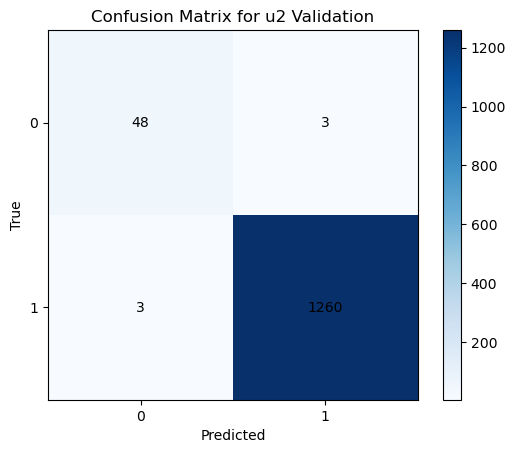

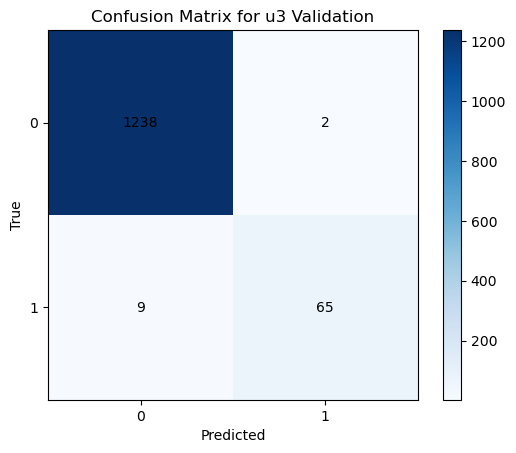

In [96]:
# create a confusion matrix of the best model for u2 
conf_matrix_u2 = confusion_matrix(y_u2_val, best_y_u2_val_pred)
plt.imshow(conf_matrix_u2, cmap='Blues')
plt.title(f'Confusion Matrix for u2 Validation')
for i in range(conf_matrix_u2.shape[0]):
    for j in range(conf_matrix_u2.shape[1]):
        plt.text(j, i, conf_matrix_u2[i, j], ha='center', va='center')
plt.colorbar()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])
plt.show()

# create a confusion matrix of the best model for u3
conf_matrix_u3 = confusion_matrix(y_u3_val, best_y_u3_val_pred)
plt.imshow(conf_matrix_u3, cmap='Blues')
plt.title(f'Confusion Matrix for u3 Validation')
for i in range(conf_matrix_u3.shape[0]):
    for j in range(conf_matrix_u3.shape[1]):
        plt.text(j, i, conf_matrix_u3[i, j], ha='center', va='center')
plt.colorbar()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])
plt.show()


In [97]:
# check if the best model's weather features are excluded
best_u2_model_weather = SVM_u2_results.loc[0]['weather_features']
best_u3_model_weather = SVM_u3_results.loc[0]['weather_features']

# drop the weather columns if the best model's weather features are excluded
if best_u2_model_weather == 'No' and best_u3_model_weather == 'No':
    x_train = x_train.drop(columns=['wind_speed', 'temperature', 'humidity', 'radiation', 'precipitation'])
    x_test = x_test.drop(columns=['wind_speed', 'temperature', 'humidity', 'radiation', 'precipitation'])

# standardize the test set
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# predict the u2 and u3 for the test set
y_u2_test_pred = best_u2_model.predict(x_test_scaled)
y_u3_test_pred = best_u3_model.predict(x_test_scaled)

# evaluate the best model for u2 and u3
u2_accuracy_test, u2_precision_test, u2_recall_test, u2_f1_test = evaluate_classification_model(y_u2_test, y_u2_test_pred, "Test u2", pos_label=0)
u3_accuracy_test, u3_precision_test, u3_recall_test, u3_f1_test = evaluate_classification_model(y_u3_test, y_u3_test_pred, "Test u3", pos_label=1)

Test u2 Performance:
Accuracy: 0.9931506849315068
Precision: 0.9523809523809523
Recall: 0.9090909090909091
F1 Score: 0.9302325581395349
Test u3 Performance:
Accuracy: 0.9908675799086758
Precision: 0.9848484848484849
Recall: 0.8552631578947368
F1 Score: 0.9154929577464789


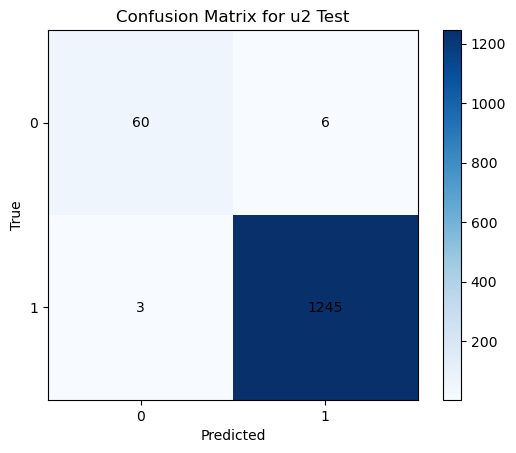

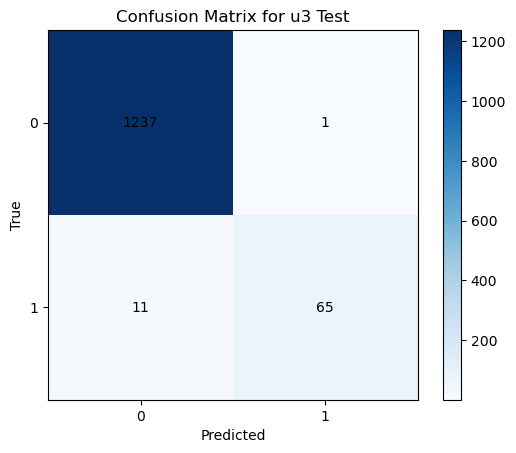

In [98]:
# plot the confusion matrix for the test set
conf_matrix_u2_test = confusion_matrix(y_u2_test, y_u2_test_pred)
plt.imshow(conf_matrix_u2_test, cmap='Blues')
plt.title(f'Confusion Matrix for u2 Test')
for i in range(conf_matrix_u2_test.shape[0]):
    for j in range(conf_matrix_u2_test.shape[1]):
        plt.text(j, i, conf_matrix_u2_test[i, j], ha='center', va='center')
plt.colorbar()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])
plt.show()
conf_matrix_u3_test = confusion_matrix(y_u3_test, y_u3_test_pred)
plt.imshow(conf_matrix_u3_test, cmap='Blues')
plt.title(f'Confusion Matrix for u3 Test')
for i in range(conf_matrix_u3_test.shape[0]):
    for j in range(conf_matrix_u3_test.shape[1]):
        plt.text(j, i, conf_matrix_u3_test[i, j], ha='center', va='center')
plt.colorbar()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])
plt.show()